## Read original data

In [28]:
import pyodbc
import pandas as pd

# Establish connection to SQL Server
conn = pyodbc.connect(
    'DRIVER={ODBC Driver 17 for SQL Server};'
    'SERVER=DESKTOP-UQDT40R;'
    'DATABASE=wallet;'
    "Trusted_Connection=yes;"
)

# Query to fetch transaction data with sender and recipient
query = """
SELECT 
    ISNULL(sender_key, recipient_key) AS user_id, -- Use sender_key if not null, otherwise use recipient_key
    CASE
        WHEN sender_key IS NOT NULL THEN 'sent'
        WHEN recipient_key IS NOT NULL THEN 'received'
    END AS transaction_role,
    transaction_type_key,
    amount,
    transaction_date
FROM 
    fact_transactions
WHERE 
    sender_key IS NOT NULL OR recipient_key IS NOT NULL
"""

# Load data into a pandas DataFrame
data = pd.read_sql(query, conn)
conn.close()

# Display the data
print(data)


      user_id transaction_role  transaction_type_key  amount  \
0           1         received                     3  1000.0   
1           1         received                     3  2000.0   
2           2             sent                     5   100.0   
3           1             sent                     4   150.0   
4           1             sent                     1   100.0   
...       ...              ...                   ...     ...   
3134        6             sent                     5  1000.0   
3135        6         received                     3  8000.0   
3136        6             sent                     5  7000.0   
3137        6             sent                     5  1000.0   
3138        6             sent                     4  1000.0   

            transaction_date  
0    2024-11-10 14:19:24.733  
1    2024-11-10 14:19:39.250  
2    2024-11-10 14:19:53.793  
3    2024-11-10 14:20:27.777  
4    2024-11-10 14:36:34.420  
...                      ...  
3134 2024-12-0

C:\Users\2\AppData\Local\Temp\ipykernel_8200\1708221213.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query, conn)


## Make one colume for users

In [29]:
import pyodbc
import pandas as pd
from scipy.stats import zscore

# Connect to SQL Server
connection = pyodbc.connect(
    "Driver={SQL Server};"
    "Server=DESKTOP-UQDT40R;"
    "Database=wallet;"
    "Trusted_Connection=yes;"
)

# Fetch the combined user transaction data
query = """
SELECT 
    user_id,
    amount,
    transaction_date
FROM (
    SELECT sender_key AS user_id, amount, transaction_date
    FROM fact_transactions
    WHERE sender_key IS NOT NULL
    
    UNION ALL
    
    SELECT recipient_key AS user_id, amount, transaction_date
    FROM fact_transactions
    WHERE recipient_key IS NOT NULL
) AS combined_users;
"""
# Load the data into a Pandas DataFrame
transactions = pd.read_sql(query, connection)
print(transactions)
# Close the connection
connection.close()




      user_id   amount        transaction_date
0           2    100.0 2024-11-10 14:19:53.793
1           1    150.0 2024-11-10 14:20:27.777
2           1    100.0 2024-11-10 14:36:34.420
3           2    100.0 2024-11-10 14:36:49.253
4           1    200.0 2024-11-15 23:37:36.670
...       ...      ...                     ...
3685        4   9000.0 2024-12-06 22:10:55.147
3686        3  15000.0 2024-12-06 22:19:26.647
3687        3   8000.0 2024-12-06 22:34:37.883
3688        6   8000.0 2024-12-07 01:46:09.383
3689        3   1000.0 2024-12-07 01:48:36.327

[3690 rows x 3 columns]


C:\Users\2\AppData\Local\Temp\ipykernel_8200\4216170952.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  transactions = pd.read_sql(query, connection)


## Compute Z-scores and store anomalous transctions


In [30]:
# Group by user_id and compute Z-scores for the amount column within each group
transactions['z_score'] = transactions.groupby('user_id')['amount'].transform(zscore)

# Identify anomalies (e.g., Z-score > 3 or Z-score < -3)
anomalies = transactions[(transactions['z_score'] > 3) | (transactions['z_score'] < -3)]

# Save the result to a CSV file for review
transactions.to_csv('user_transactions_with_z_scores.csv', index=False)
anomalies.to_csv('anomalous_transactions.csv', index=False)

print("Z-scores computed and saved to CSV files.")
print(f"Number of anomalous transactions: {len(anomalies)}")


Z-scores computed and saved to CSV files.
Number of anomalous transactions: 31


In [31]:
##real time z score

## Plotting Z-scores distribution for each user

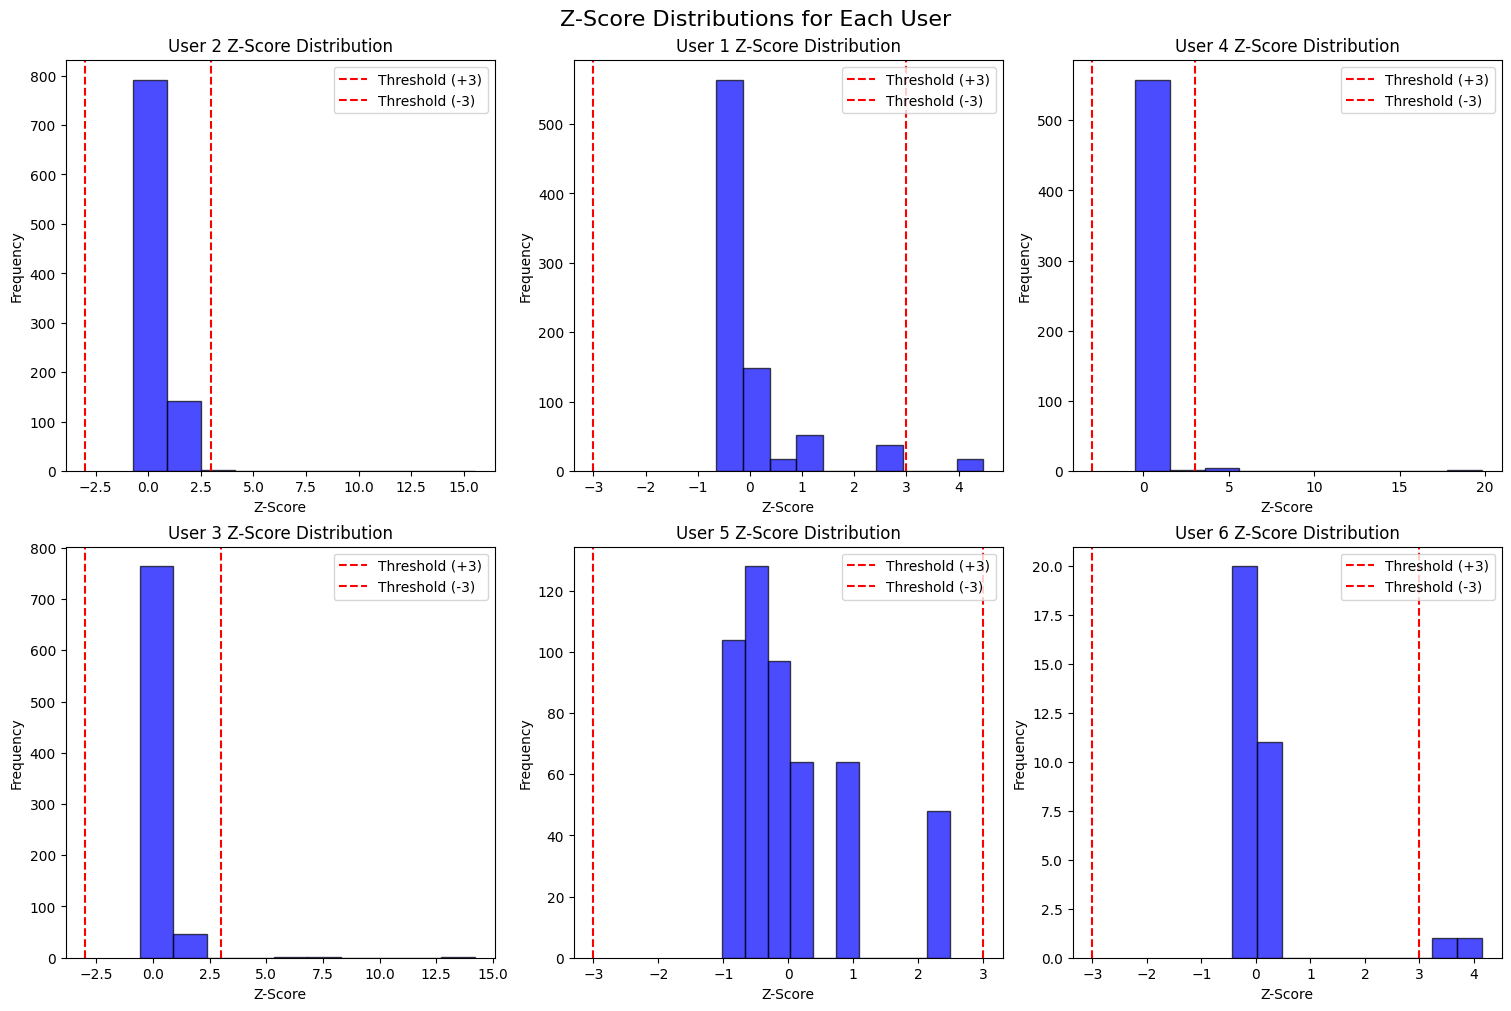

In [32]:
import matplotlib.pyplot as plt

unique_users = transactions['user_id'].unique()
num_users = len(unique_users)

# Configure the plot layout based on the number of users
rows = (num_users // 3) + (num_users % 3 > 0)  # 3 columns per row
cols = min(3, num_users)

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5), constrained_layout=True)
axes = axes.flatten()

for i, user_id in enumerate(unique_users):
    cluster_data = transactions[transactions['user_id'] == user_id]
    axes[i].hist(cluster_data['z_score'], bins=10, alpha=0.7, color='blue', edgecolor='black')
    axes[i].set_title(f'User {user_id} Z-Score Distribution')
    axes[i].axvline(3, color='red', linestyle='--', label='Threshold (+3)')
    axes[i].axvline(-3, color='red', linestyle='--', label='Threshold (-3)')
    axes[i].set_xlabel('Z-Score')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Show the plot
plt.suptitle('Z-Score Distributions for Each User', fontsize=16)
plt.show()


## User anomaly ranges

In [33]:
# Calculate mean and standard deviation for each user
user_stats = transactions.groupby('user_id')['amount'].agg(['mean', 'std'])

# Define the threshold multiplier (e.g., 3 for ±3 standard deviations)
n = 3

# Calculate the anomaly thresholds (lower and upper)
user_stats['lower_threshold'] = user_stats['mean'] - n * user_stats['std']
user_stats['upper_threshold'] = user_stats['mean'] + n * user_stats['std']

# Print the table showing the anomaly ranges for each user
print("Anomaly ranges for each user:")
print(user_stats)

# To save the results to a CSV file
output_file = "user_anomaly_ranges.csv"
user_stats.to_csv(output_file)

print(f"Anomaly ranges saved to: {output_file}")

Anomaly ranges for each user:
                mean          std  lower_threshold  upper_threshold
user_id                                                            
1         386.858852   584.444269     -1366.473955      2140.191658
2         411.723291   553.255985     -1248.044666      2071.491247
3         619.916564  1012.413569     -2417.324141      3657.157270
4         226.883186   442.501589     -1100.621582      1554.387954
5         319.326733   274.273105      -503.492583      1142.146049
6        1389.393939  1617.808972     -3464.032978      6242.820857
Anomaly ranges saved to: user_anomaly_ranges.csv


## K-Mean

In [34]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Map the transaction_type_key to transaction type names
transaction_type_mapping = {
    1: "airtime",
    2: "bill",
    3: "deposit",
    4: "transfer",
    5: "withdraw"
}

kmean_data = data
# Map the numeric keys to their respective names
kmean_data['transaction_type'] = kmean_data['transaction_type_key'].map(transaction_type_mapping)

# Drop the old numeric transaction_type_key column
kmean_data = kmean_data.drop(columns=['transaction_type_key'])

# Ensure all column names are strings
kmean_data.columns = kmean_data.columns.astype(str)

# Handle missing values (if any)
kmean_data = kmean_data.fillna(0)

# Prepare data for clustering
# Drop non-numeric or non-relevant columns (like transaction_date)
clustering_data = kmean_data.drop(columns=['transaction_type', 'transaction_date', 'transaction_id', 'transaction_key','transaction_role'], errors='ignore')

# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(clustering_data)
# print(normalized_data)

# Perform K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmean_data['cluster'] = kmeans.fit_predict(normalized_data)

# Example: Count transactions per cluster
cluster_summary = kmean_data.groupby('cluster').size()
print("\nTransactions per Cluster:")
print(cluster_summary)





Transactions per Cluster:
cluster
0    1436
1     420
2    1283
dtype: int64


In [35]:
# Analyze the transaction types and amount within each cluster
cluster_summary2 = kmean_data.groupby('cluster').agg({
    'transaction_type': lambda x: x.mode()[0],  # Most common transaction type
    'amount': 'mean',  # Average amount per cluster
})

print(cluster_summary2)


        transaction_type       amount
cluster                              
0               withdraw   243.201253
1                deposit  1720.357143
2               transfer   233.454404


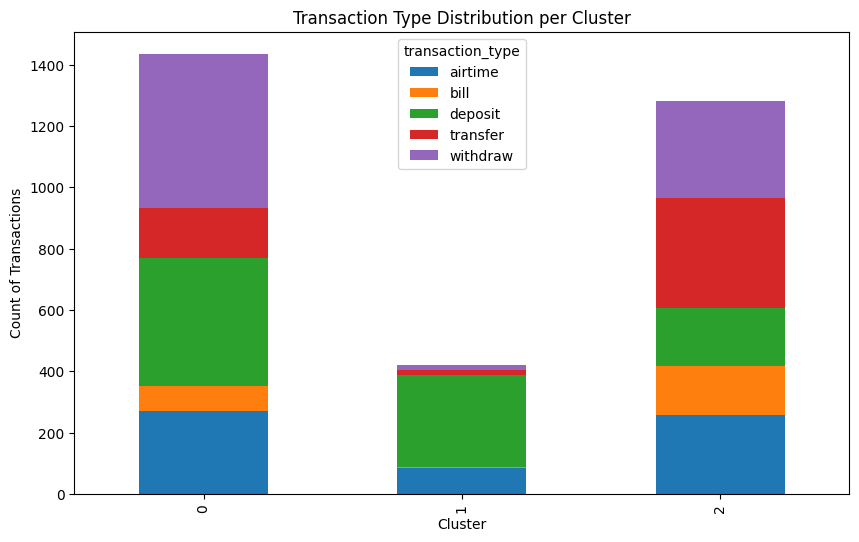

In [36]:
import matplotlib.pyplot as plt

# Plot the distribution of transaction types in each cluster
cluster_counts = kmean_data.groupby(['cluster', 'transaction_type']).size().unstack().fillna(0)
cluster_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Transaction Type Distribution per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count of Transactions')
plt.show()


In [37]:
## look in kmean

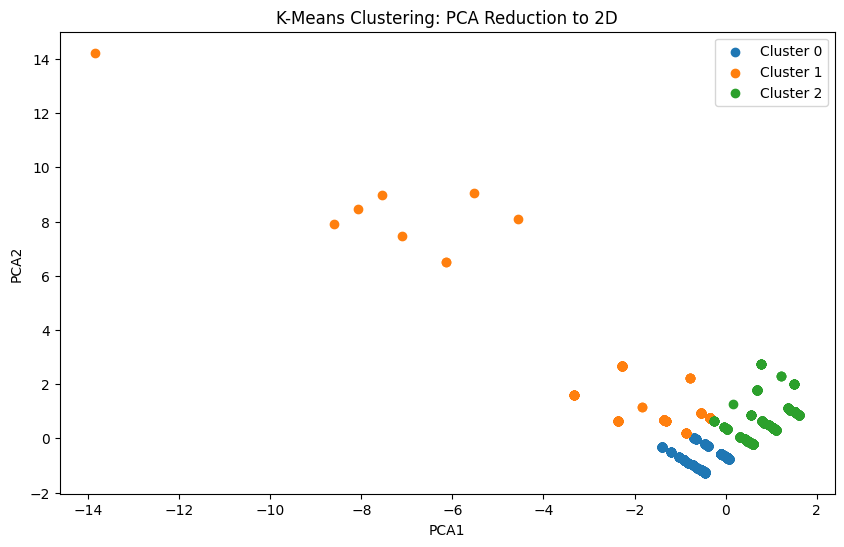

In [38]:
from sklearn.decomposition import PCA

# Reducing the data to 2D using PCA for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(normalized_data)

# Create a DataFrame with PCA results and clusters
pca_df = pd.DataFrame(reduced_data, columns=['PCA1', 'PCA2'])
pca_df['cluster'] = kmean_data['cluster']

# Plotting the clusters in 2D space
plt.figure(figsize=(10, 6))
for cluster in pca_df['cluster'].unique():
    cluster_data = pca_df[pca_df['cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}')
    
plt.title('K-Means Clustering: PCA Reduction to 2D')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()


In [39]:
# print(transactions)
print(kmean_data)

      user_id transaction_role  amount        transaction_date  \
0           1         received  1000.0 2024-11-10 14:19:24.733   
1           1         received  2000.0 2024-11-10 14:19:39.250   
2           2             sent   100.0 2024-11-10 14:19:53.793   
3           1             sent   150.0 2024-11-10 14:20:27.777   
4           1             sent   100.0 2024-11-10 14:36:34.420   
...       ...              ...     ...                     ...   
3134        6             sent  1000.0 2024-12-07 01:27:58.663   
3135        6         received  8000.0 2024-12-07 01:46:09.383   
3136        6             sent  7000.0 2024-12-07 01:46:28.833   
3137        6             sent  1000.0 2024-12-07 01:47:56.060   
3138        6             sent  1000.0 2024-12-07 01:48:36.327   

     transaction_type  cluster  
0             deposit        0  
1             deposit        1  
2            withdraw        0  
3            transfer        0  
4             airtime        0  
...      

## Filter heavy deposit and check if happen any heavy withdraw

In [40]:
import pandas as pd
from scipy.stats import zscore
import pyodbc

# Connect to SQL Server
connection = pyodbc.connect(
    "Driver={SQL Server};"
    "Server=DESKTOP-UQDT40R;"
    "Database=wallet;"
    "Trusted_Connection=yes;"
)

# Sample query to fetch data (including sender_key and recipient_key)
query = """
SELECT 
    user_id,
    amount,
    transaction_type,
    transaction_date
FROM (
    SELECT sender_id AS user_id, amount, transaction_type, transaction_date
    FROM PartitionedTransactions
    WHERE sender_id IS NOT NULL
    
    UNION ALL
    
    SELECT recipient_id AS user_id, amount, transaction_type, transaction_date
    FROM PartitionedTransactions
    WHERE recipient_id IS NOT NULL
) AS combined_users;
"""

# Load the data into a Pandas DataFrame
trial = pd.read_sql(query, connection)

# Close the database connection
connection.close()

# Assuming you have clustering results in 'kmean_data'



C:\Users\2\AppData\Local\Temp\ipykernel_8200\2831153464.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  trial = pd.read_sql(query, connection)


In [41]:
# Find deposit-heavy users
# Step 1: Calculate the percentage of deposit transactions per user
transaction_summary = trial.groupby(['user_id', 'transaction_type']).size().unstack(fill_value=0)

# Add a column for the total number of transactions per user
transaction_summary['total_transactions'] = transaction_summary.sum(axis=1)

# Calculate the percentage of deposits for each user
transaction_summary['deposit_percentage'] = (transaction_summary.get('deposit', 0) / transaction_summary['total_transactions']) * 100

# Define the threshold for "deposit-heavy" (e.g., >70%)
deposit_threshold = 40
deposit_heavy_users = transaction_summary[transaction_summary['deposit_percentage'] > deposit_threshold].index

# Step 2: Filter transactions for deposit-heavy users
deposit_heavy_transactions = trial[trial['user_id'].isin(deposit_heavy_users)]
trialfile = 'trialfile.csv'
deposit_heavy_transactions.to_csv(trialfile, index =False)


deposit_heavy_cluster = deposit_heavy_transactions[deposit_heavy_transactions['transaction_type'] == 'deposit']
deposit_heavy_users = deposit_heavy_cluster['user_id'].unique()
print(deposit_heavy_users)
# Filter withdrawal transactions from deposit-heavy users
withdrawal_transactions = deposit_heavy_transactions[deposit_heavy_transactions['transaction_type'] == 'withdraw']

# Now let's calculate the Z-score for the withdrawal amounts to detect anomalies
withdrawal_transactions['z_score'] = withdrawal_transactions.groupby('user_id')['amount'].transform(zscore)

# Define the anomaly threshold (e.g., Z-score > 3 or Z-score < -3)
threshold = 3
anomalous_withdrawals = withdrawal_transactions[withdrawal_transactions['z_score'].abs() > threshold]

# Save the anomalous withdrawals to a CSV file
output_file = "anomalous_withdrawals.csv"
anomalous_withdrawals.to_csv(output_file, index=False)

print(f"Anomalous withdrawals saved to: {output_file}")

[6]
Anomalous withdrawals saved to: anomalous_withdrawals.csv


C:\Users\2\AppData\Local\Temp\ipykernel_8200\3565431682.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  withdrawal_transactions['z_score'] = withdrawal_transactions.groupby('user_id')['amount'].transform(zscore)


## Isolation Forset

In [42]:
## isolation forset is similar to randon forset but there some changes between them
## isolation forset make spliting for data which take randome point(node) and make split data if there any anomulies it easy to detect
## Make multible diffrenet tree and if point is anomilies will be anomilies in all trees
#  Give score for every data point if it above thershold it will be anomulis 

In [43]:
print (data)

      user_id transaction_role  transaction_type_key  amount  \
0           1         received                     3  1000.0   
1           1         received                     3  2000.0   
2           2             sent                     5   100.0   
3           1             sent                     4   150.0   
4           1             sent                     1   100.0   
...       ...              ...                   ...     ...   
3134        6             sent                     5  1000.0   
3135        6         received                     3  8000.0   
3136        6             sent                     5  7000.0   
3137        6             sent                     5  1000.0   
3138        6             sent                     4  1000.0   

            transaction_date transaction_type  
0    2024-11-10 14:19:24.733          deposit  
1    2024-11-10 14:19:39.250          deposit  
2    2024-11-10 14:19:53.793         withdraw  
3    2024-11-10 14:20:27.777         tr

In [44]:
from sklearn.ensemble import IsolationForest
forest_data = data
# Select features for anomaly detection (e.g., 'amount', 'sender_key', etc.)
features = forest_data[['amount', 'user_id', 'transaction_type_key']]

# Fit the Isolation Forest model
iso_forest = IsolationForest(contamination=0.01)  # 1% contamination assumed for anomaly
forest_data['anomaly'] = iso_forest.fit_predict(features)

# Convert -1 (anomaly) and 1 (normal) to boolean
forest_data['is_anomaly'] = forest_data['anomaly'] == -1

# Show anomalies
anomalous_data = forest_data[forest_data['is_anomaly'] == True]
output_file = "forest_data_anomuls.csv"
anomalous_data.to_csv(output_file, index=False)
print(forest_data)


      user_id transaction_role  transaction_type_key  amount  \
0           1         received                     3  1000.0   
1           1         received                     3  2000.0   
2           2             sent                     5   100.0   
3           1             sent                     4   150.0   
4           1             sent                     1   100.0   
...       ...              ...                   ...     ...   
3134        6             sent                     5  1000.0   
3135        6         received                     3  8000.0   
3136        6             sent                     5  7000.0   
3137        6             sent                     5  1000.0   
3138        6             sent                     4  1000.0   

            transaction_date transaction_type  anomaly  is_anomaly  
0    2024-11-10 14:19:24.733          deposit        1       False  
1    2024-11-10 14:19:39.250          deposit        1       False  
2    2024-11-10 14:19:53

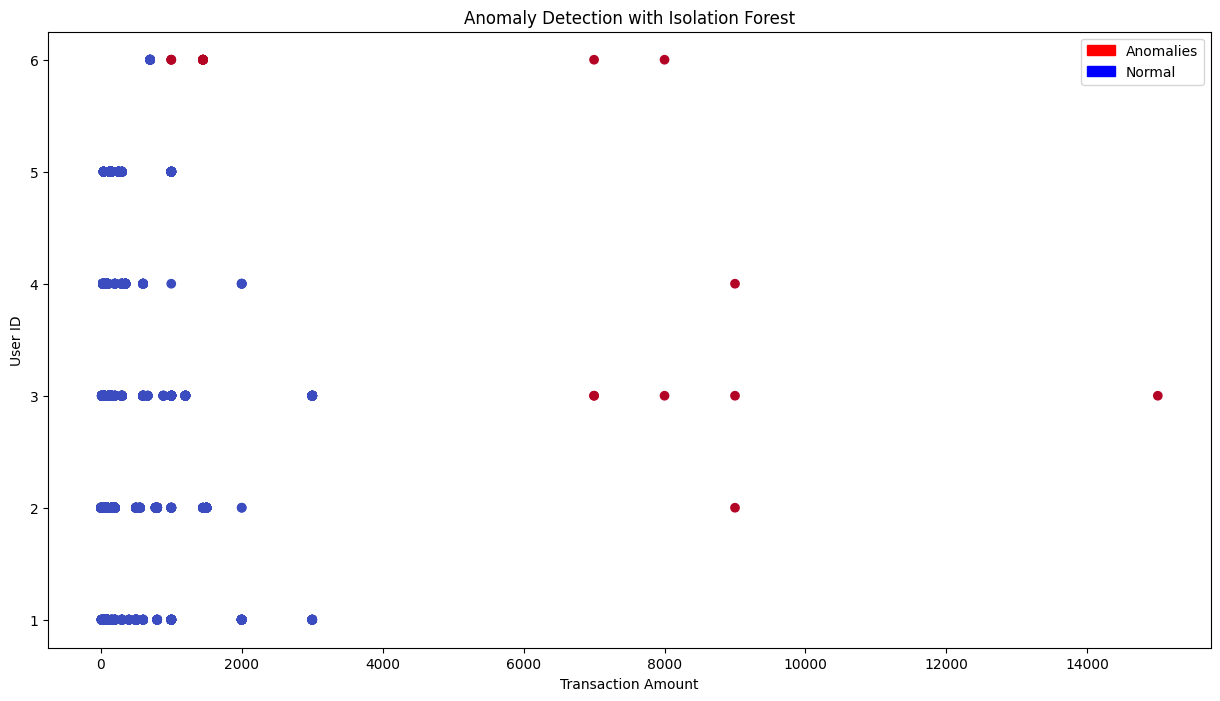

In [45]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.figure(figsize=(15, 8))

# Create the scatter plot
plt.scatter(forest_data['amount'], forest_data['user_id'], 
            c=forest_data['is_anomaly'], cmap='coolwarm', label='Anomalies')

# Add a custom legend for the red points (anomalies)
red_patch = mpatches.Patch(color='red', label='Anomalies')
blue_patch = mpatches.Patch(color='blue', label='Normal')

# Add the legend to the plot
plt.legend(handles=[red_patch, blue_patch])

# Add labels and title
plt.title('Anomaly Detection with Isolation Forest')
plt.xlabel('Transaction Amount')
plt.ylabel('User ID')

# Show the plot
plt.show()


## Local Outlier Factor

In [46]:
## LOF is based on denstiy technique
## i go for every point and calculate distance from neighbours points 
## points which is outlier the diffrenece will be bigger than difference between neighbours based on hyper parameter K
## Density of ourlier <<< density of neighbours of outlier 

In [47]:
from sklearn.neighbors import LocalOutlierFactor
data_lof = data
# Fit LOF model
# Select features for LOF (e.g., 'amount', 'user_id', 'transaction_type_key')
features = data_lof[['amount', 'user_id', 'transaction_type_key']]

# Fit the LOF model and predict anomalies
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
# data_lof['is_anomaly'] = lof.fit_predict(features)  # LOF returns -1 for anomalies
data_lof['is_anomaly'] = lof.fit_predict(features) == 1  # Convert to True/False for clarity
# Separate normal data and anomalies for visualization
normal_data_lof = data_lof
# anomalous_data_lof = data_lof[data_lof['is_anomaly'] == -1]
anomalous_data_lof = data_lof[(data_lof['is_anomaly'] == True) & (data_lof['anomaly'] == -1)]

output_file = "LOF_data_anomuls.csv"
anomalous_data_lof.to_csv(output_file, index=False)
print(anomalous_data_lof)


      user_id transaction_role  transaction_type_key  amount  \
832         6         received                     3  1450.0   
937         6         received                     3  1450.0   
1118        6         received                     3  1450.0   
1323        6         received                     3  1450.0   
1523        6         received                     3  1450.0   
1723        6         received                     3  1450.0   
1927        6         received                     3  1450.0   
2186        6         received                     3  1450.0   
2435        6         received                     3  1450.0   
2699        6         received                     3  1450.0   
2963        6         received                     3  1450.0   
3134        6             sent                     5  1000.0   
3137        6             sent                     5  1000.0   
3138        6             sent                     4  1000.0   

            transaction_date transactio

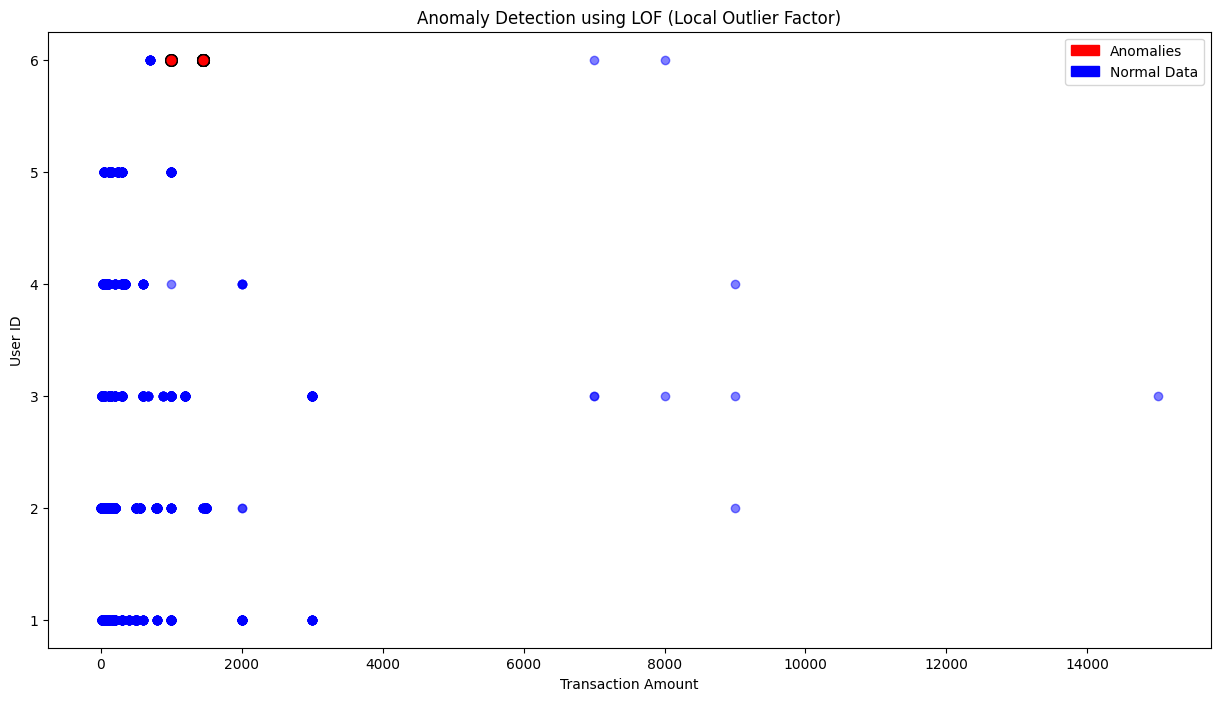

In [48]:
# Visualization
plt.figure(figsize=(15, 8))  # Increase plot size

# Plot normal data points in blue
plt.scatter(normal_data_lof['amount'], normal_data_lof['user_id'], 
            color='blue', label='Normal Data', alpha=0.5)

# Plot anomalies in red
plt.scatter(anomalous_data_lof['amount'], anomalous_data_lof['user_id'], 
            color='red', label='Anomalies', edgecolor='black', s=70)

# Add legend and labels
plt.title('Anomaly Detection using LOF (Local Outlier Factor)')
plt.xlabel('Transaction Amount')
plt.ylabel('User ID')

# Custom legend
red_patch = mpatches.Patch(color='red', label='Anomalies')
blue_patch = mpatches.Patch(color='blue', label='Normal Data')
plt.legend(handles=[red_patch, blue_patch])

# Show the plot
plt.show()

## Support Vector Machine

In [49]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, f1_score
import numpy as np

# -------------------------
# Load and Copy Data
# -------------------------
# Ensure 'data' is loaded as a DataFrame before running this script
data_svm = data

# -------------------------
# Feature Selection
# -------------------------
# Select features for SVM-based anomaly detection (ensure only numeric columns)
features_svm = data_svm[['amount', 'user_id', 'transaction_type_key']]

# -------------------------
# Data Normalization
# -------------------------
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_svm)

# -------------------------
# Define Custom Scoring Function for GridSearchCV
# -------------------------
def custom_f1_score(y_true, y_pred):
    """
    Custom F1-score function.
    One-Class SVM outputs 1 (normal) and -1 (anomalous).
    """
    return f1_score(y_true, y_pred)

# Create synthetic labels (all data is treated as 'inliers' for GridSearchCV)
y_labels = np.ones(features_scaled.shape[0])

# Wrap the custom scoring function
scorer = make_scorer(custom_f1_score, greater_is_better=True)

# -------------------------
# Define Grid Search Parameters
# -------------------------
param_grid = {
    'gamma': [0.01, 0.1, 0.2, 0.5],
    'nu': [0.01, 0.05, 0.1, 0.2]
}

# -------------------------
# Grid Search for One-Class SVM
# -------------------------
best_params = None
try:
    print("Performing Grid Search for One-Class SVM...")
    grid_search = GridSearchCV(
        estimator=OneClassSVM(kernel="rbf"),
        param_grid=param_grid,
        scoring=scorer,  # Use custom F1-score
        cv=3,
        verbose=1
    )
    grid_search.fit(features_scaled, y_labels)  # Pass synthetic labels
    best_params = grid_search.best_params_
    print(f"Best Parameters Found: {best_params}")
except Exception as e:
    print("Grid search failed. Using default parameters.", e)
    best_params = {'gamma': 0.2, 'nu': 0.01}

# -------------------------
# Train One-Class SVM with Best Parameters
# -------------------------
svm_model = OneClassSVM(kernel="rbf", gamma=best_params['gamma'], nu=best_params['nu'])
svm_model.fit(features_scaled)

# -------------------------
# Predict Anomalies
# -------------------------
# Make predictions (1 for normal, -1 for anomaly)
data_svm['is_anomaly'] = svm_model.predict(features_scaled) == -1  # Convert to True/False for clarity

# -------------------------
# Separate and Save Anomalous Data
# -------------------------
normal_data_svm = data_svm[~data_svm['is_anomaly']]
# anomalous_data_svm = data_svm[data_svm['is_anomaly']]
anomalous_data_svm = data_svm[(data_svm['is_anomaly'] == True) & (data_svm['anomaly'] == -1)]

# Save anomalous data to a CSV file
output_file = "anomalous_data_svm.csv"
anomalous_data_svm.to_csv(output_file, index=False)

# -------------------------
# Display Results
# -------------------------
print("Anomalous Data:")
print(anomalous_data_svm)

Performing Grid Search for One-Class SVM...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters Found: {'gamma': 0.01, 'nu': 0.01}
Anomalous Data:
      user_id transaction_role  transaction_type_key   amount  \
3126        2         received                     3   9000.0   
3128        3             sent                     5   7000.0   
3129        4         received                     3   9000.0   
3130        3             sent                     5   7000.0   
3131        3             sent                     5   9000.0   
3132        3         received                     3  15000.0   
3133        3         received                     3   8000.0   
3134        6             sent                     5   1000.0   
3135        6         received                     3   8000.0   
3136        6             sent                     5   7000.0   
3137        6             sent                     5   1000.0   

            transaction_date transaction_type  

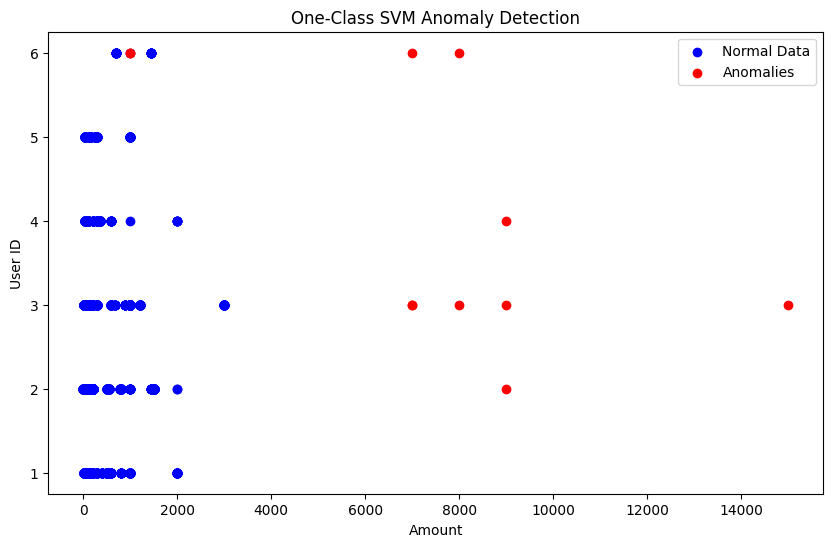

In [50]:
# Optional: Plotting the anomalies for visualization
plt.figure(figsize=(10, 6))
plt.scatter(normal_data_svm['amount'], normal_data_svm['user_id'], color='blue', label='Normal Data')
plt.scatter(anomalous_data_svm['amount'], anomalous_data_svm['user_id'], color='red', label='Anomalies')
plt.xlabel('Amount')
plt.ylabel('User ID')
plt.title('One-Class SVM Anomaly Detection')
plt.legend()
plt.show()